Loaded positions: (1000, 2) activations: (1000, 100)
Place cells indices: []
Spatial info (first 10): [0.0868, 0.0861, 0.0869, 0.0874, 0.088, 0.0871, 0.0862, 0.0872, 0.0872, 0.0872]
Sparsity (first 10): [0.911, 0.9114, 0.9109, 0.9102, 0.9095, 0.9106, 0.9114, 0.9105, 0.9104, 0.9104]


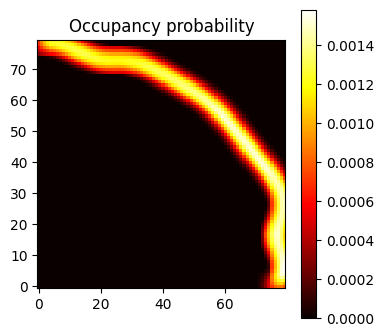

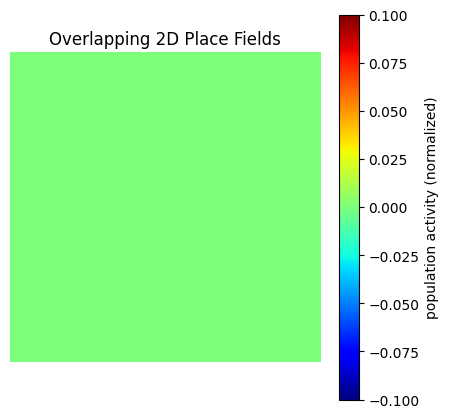

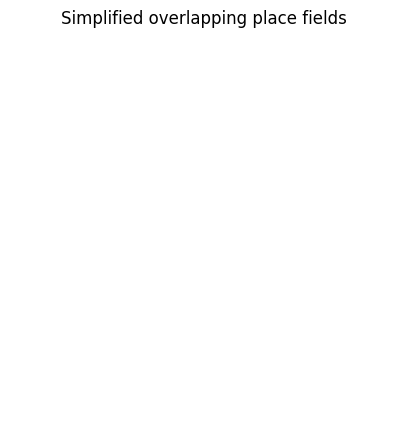

In [6]:
# 2D place-field pipeline (compact, step-by-step)
# Requirements: numpy, scipy, matplotlib, pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pickle
import math
import os

epsilon = 1e-10

# -------------------------
# I/O: load trajectory + activations
# -------------------------
def load_data(activation_path, trajectory_path):
    with open(trajectory_path, 'rb') as f:
        data_pos = pickle.load(f)
    with open(activation_path, 'rb') as f:
        activations = pickle.load(f)

    x = np.asarray(data_pos['x'])
    y = np.asarray(data_pos['y'])
    positions = np.column_stack((x, y))           # shape (T,2)

    activations = np.asarray(activations)
    # Ensure activations shape is (T, N)
    if activations.ndim == 2 and activations.shape[0] != positions.shape[0]:
        activations = activations.T

    return positions, activations

# -------------------------
# small helper: normalized 2D gaussian kernel like MATLAB fspecial('gaussian')
# -------------------------
def matlab_style_gauss2D(shape=(9,9), sigma=3.0):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# -------------------------
# Occupancy histogram (2D) -> returns probability, edges and smoothed raw counts
# -------------------------
def occupancy_map_func(positions, reso=40, win_len=9, sigma=3.0):
    x = positions[:,0]; y = positions[:,1]
    bins = (reso*2, reso*2)   # consistent with your previous choices
    H_raw, xedges, yedges = np.histogram2d(x, y, bins=bins)
    gauss = matlab_style_gauss2D((win_len, win_len), sigma=sigma)
    H_smooth = scipy.signal.convolve2d(H_raw, gauss, mode='same', boundary='fill', fillvalue=0)
    total = np.nansum(H_smooth)
    occ_prob = H_smooth / (total + epsilon) if total>0 else H_smooth
    return occ_prob, xedges, yedges, H_smooth

# -------------------------
# Firing-rate map for one neuron (2D)
# -------------------------
def firing_rate_map_2d(single_activation, positions, occ_tuple, thresh_param=0.0, win_len=9, sigma=3.0):
    occ_prob, xedges, yedges, H_raw = occ_tuple

    # threshold to choose "spikes" or suprathreshold activations
    mean_r = np.nanmean(single_activation)
    std_r = np.nanstd(single_activation)
    thresh = mean_r + thresh_param * std_r

    spike_idx = np.where(single_activation > thresh)[0]
    spike_pos = positions[spike_idx] if spike_idx.size>0 else np.zeros((0,2))

    # histogram of spikes into same bins
    if spike_pos.shape[0] == 0:
        H_spikes = np.zeros_like(H_raw)
    else:
        H_spikes, _, _ = np.histogram2d(spike_pos[:,0], spike_pos[:,1], bins=[xedges, yedges])

    # compute rate: spike counts divided by occupancy counts (H_raw smoothed)
    fr_map = H_spikes / (H_raw + epsilon)

    # smooth firing map for visualization
    gauss = matlab_style_gauss2D((win_len, win_len), sigma=sigma)
    fr_map_smooth = scipy.signal.convolve2d(fr_map, gauss, mode='same', boundary='fill', fillvalue=0)

    # prepare a plotting version: mask bins that had zero occupancy
    fr_map_plot = fr_map_smooth.copy()
    fr_map_plot[H_raw == 0] = np.nan

    # normalized version 0..1 for visualization overlays
    finite = fr_map_smooth[H_raw>0]
    if finite.size == 0:
        fr_map_norm = fr_map_plot
    else:
        mn, mx = finite.min(), finite.max()
        if mx - mn < 1e-12:
            fr_map_norm = fr_map_plot - mn
        else:
            fr_map_norm = (fr_map_plot - mn) / (mx - mn)

    return fr_map_smooth, fr_map_norm, spike_pos, H_raw, xedges, yedges

# -------------------------
# Spatial information (Skaggs) + sparsity
# -------------------------
def inf_rate(rate_map, occ_counts):
    occ_counts = np.array(occ_counts, dtype=float)
    total = np.nansum(occ_counts)
    if total <= 0:
        return 0.0, 0.0
    px = occ_counts / (total + epsilon)   # occupancy probability per bin
    rate = np.array(rate_map, dtype=float)
    rate_flat = rate.copy()
    rate_flat[np.isnan(rate_flat)] = 0.0
    avg_rate = np.sum(rate_flat * px)
    if avg_rate <= 0:
        return 0.0, avg_rate
    ratio = np.zeros_like(rate_flat)
    nonzero = rate_flat > 0
    ratio[nonzero] = rate_flat[nonzero] / (avg_rate + epsilon)
    info_map = np.zeros_like(rate_flat)
    info_map[nonzero] = ratio[nonzero] * np.log2(np.maximum(ratio[nonzero], epsilon))
    info = np.nansum(info_map * px)
    return float(info), float(avg_rate)

def sparsity_func(occ_prob, fr_map):
    px = np.array(occ_prob, dtype=float)
    px[np.isnan(px)] = 0.0
    total = np.nansum(px)
    if total <= 0:
        return 0.0
    px_norm = px / (total + epsilon)
    fr = fr_map.copy()
    fr[np.isnan(fr)] = 0.0
    avg_rate = np.nansum(fr * px_norm)
    numerator = avg_rate**2
    denominator = np.nansum(px_norm * (fr**2)) + epsilon
    return float(numerator / denominator)

# -------------------------
# Full scorer: iterate neurons, produce fr maps, info, sparsity
# -------------------------
def analyze_place_cells_2d(positions, activations, reso=40, lim=0.0, spi_threshold=0.3, spar_threshold=0.1, show_each=False):
    occ_prob, xedges, yedges, H_raw = occupancy_map_func(positions, reso=reso, win_len=9, sigma=3.0)
    occ_tuple = (occ_prob, xedges, yedges, H_raw)

    T, N = activations.shape
    spatial_info = []
    sparsity_scores = []
    fr_maps = []
    fr_maps_norm = []
    spike_positions = []

    for i in range(N):
        resp = activations[:, i]
        fr_smooth, fr_norm, spikes, occ_counts, xe, ye = firing_rate_map_2d(resp, positions, occ_tuple, thresh_param=lim, win_len=9, sigma=3.0)
        fr_maps.append(fr_smooth)
        fr_maps_norm.append(fr_norm)
        spike_positions.append(spikes)

        info, avg_rate = inf_rate(fr_smooth, occ_counts)
        if math.isnan(info) or avg_rate==0:
            info = 0.0
        spatial_info.append(round(info, 4))

        # compute sparsity using occ_counts -> convert to probability
        occ_prob_for_s = occ_counts.copy()
        tot = np.nansum(occ_prob_for_s)
        if tot <= 0:
            occ_prob_norm = occ_prob_for_s
        else:
            occ_prob_norm = occ_prob_for_s / (tot + epsilon)
        spars = sparsity_func(occ_prob_norm, fr_smooth)
        sparsity_scores.append(round(spars, 4))

        if show_each:
            plt.figure(figsize=(3,3))
            #plt.imshow(np.rot90(fr_smooth), origin='lower', cmap='jet')
            plt.imshow(
                np.rot90(fr_smooth),
                origin='lower',
                cmap='jet',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect='auto'
            )

            plt.title(f"Neuron {i} - info {spatial_info[-1]} spars {sparsity_scores[-1]}")
            plt.colorbar()
            plt.show()

    # identify place cells (intersection)
    spinfo_idx = np.where(np.asarray(spatial_info) > spi_threshold)[0]
    spars_idx = np.where(np.asarray(sparsity_scores) < spar_threshold)[0]
    place_cells = sorted(list(set(spinfo_idx).intersection(set(spars_idx))))

    return {
        "occ_prob": occ_prob, "xedges": xedges, "yedges": yedges,
        "fr_maps": fr_maps, "fr_maps_norm": fr_maps_norm,
        "spike_positions": spike_positions,
        "spatial_info": spatial_info, "sparsity": sparsity_scores,
        "place_cells": place_cells
    }

# -------------------------
# Combined overlapping "blue-style" plot
# -------------------------
def plot_overlapping_fields(fr_maps, place_cells, title="Overlapping 2D Place Fields", cmap='jet', alpha=0.35):
    # build combined map by summing normalized fields (use each field's normalized range)
    combined = np.zeros_like(fr_maps[0])
    for i in place_cells:
        f = fr_maps[i]
        # normalize per-field for fair overlap contribution
        f_valid = f[np.isfinite(f)]
        if f_valid.size == 0:
            continue
        mn, mx = f_valid.min(), f_valid.max()
        if mx - mn < 1e-12:
            f_norm = np.zeros_like(f)
        else:
            f_norm = (f - mn) / (mx - mn)
        # mask bins that are invalid (NaN) to zero
        f_norm[np.isnan(f_norm)] = 0.0
        combined += f_norm

    # Normalize combined to 0..1 for display
    if np.nanmax(combined) > 0:
        combined_disp = combined / (np.nanmax(combined) + epsilon)
    else:
        combined_disp = combined

    plt.figure(figsize=(5,5))
    plt.imshow(np.rot90(combined_disp), origin='lower', cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.colorbar(label='population activity (normalized)')
    plt.show()

# -------------------------
# simplified Gaussian patch + labels (literature style)
# -------------------------
def plot_simplified_fields(fr_maps, place_cells, sigma_patch=6, alpha=0.45):
    plt.figure(figsize=(5,5))
    for i in place_cells:
        fr = fr_maps[i]
        fr = np.nan_to_num(fr)
        peak_idx = np.unravel_index(np.argmax(fr), fr.shape)
        px, py = peak_idx
        rr, cc = np.meshgrid(np.arange(fr.shape[0]), np.arange(fr.shape[1]))
        patch = np.exp(-((rr-px)**2 + (cc-py)**2)/(2*sigma_patch**2))
        plt.imshow(np.rot90(patch), origin='lower', cmap='jet', alpha=alpha)
        # label near peak (adjust for rot90)
        plt.text(fr.shape[1]-py-1, px, f"N{i}", color='white', fontsize=8,
                 ha='center', va='center', weight='bold', bbox=dict(facecolor='black', alpha=0.5, pad=1))
    plt.title("Simplified overlapping place fields")
    plt.axis('off')
    plt.show()

# -------------------------
# Example usage (run end-to-end)
# -------------------------
if __name__ == "__main__":
    activation_path = "0_input_data/activations_z3_traj_5.pkl"       # replace with your file
    trajectory_path = "0_input_data/traj_5_data.pkl"      # replace with your file

    positions, activations = load_data(activation_path, trajectory_path)
    print("Loaded positions:", positions.shape, "activations:", activations.shape)

    # optional: subset neurons
    activations = activations[:, :50]

    result = analyze_place_cells_2d(positions, activations,
                                    reso=40, lim=0.0,
                                    spi_threshold=0.3, spar_threshold=0.1,
                                    show_each=False)

    print("Place cells indices:", result['place_cells'])
    print("Spatial info (first 10):", result['spatial_info'][:10])
    print("Sparsity (first 10):", result['sparsity'][:10])

    # Plot occupancy (diagnostic)
    plt.figure(figsize=(4,4))
    plt.imshow(np.rot90(result['occ_prob']), origin='lower', cmap='hot')
    plt.title("Occupancy probability")
    plt.colorbar()
    plt.show()

    # Blue-style overlapping population map
    plot_overlapping_fields(result['fr_maps'], result['place_cells'], cmap='jet', alpha=0.35)

    # Optional: simplified circular patches with labels
    plot_simplified_fields(result['fr_maps'], result['place_cells'], sigma_patch=6, alpha=0.45)


positions: (1000, 2) activations: (1000, 100)
Place cells: []
Spatial info (first 10): [0.2353, 0.1455, 0.2157, 0.3582, 0.1872, 0.4501, 0.1554, 0.3479, 0.1401, 0.1375]
Sparsity (first 10): [0.7731, 0.8545, 0.791, 0.7037, 0.8153, 0.6524, 0.8442, 0.7192, 0.8573, 0.8645]


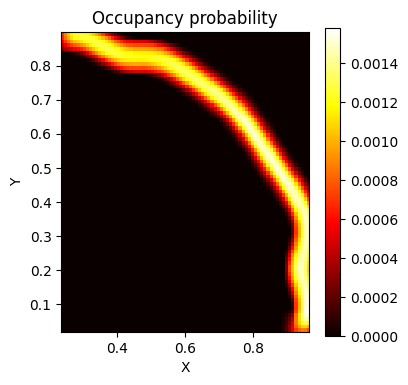

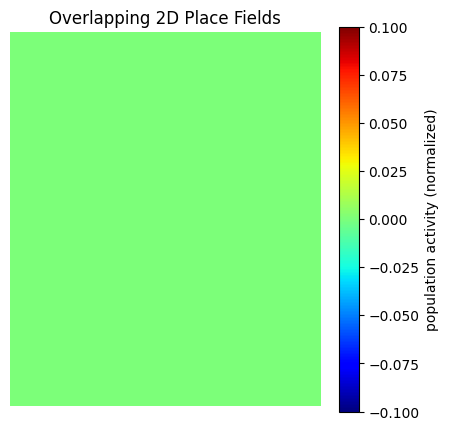

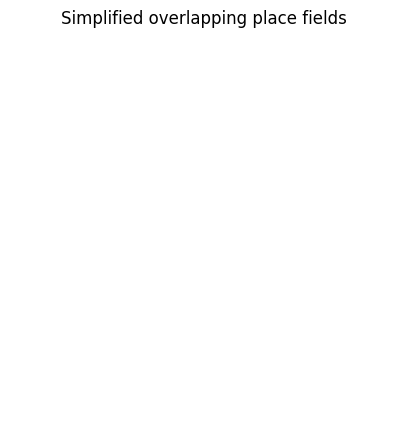

In [8]:
# 2D place-cell pipeline: minimal, direct conversion of your 1D code
# Requirements: numpy, scipy, matplotlib, pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import pickle
import math
from scipy import ndimage

epsilon = 1e-10

# -------------------------
# I/O
# -------------------------
def get_input_data_2d(activation_path, trajectory_path):
    with open(trajectory_path, 'rb') as f:
        data_pos = pickle.load(f)
    with open(activation_path, 'rb') as f:
        activations = pickle.load(f)

    x = np.asarray(data_pos['x'])
    y = np.asarray(data_pos['y'])
    positions = np.column_stack((x, y))           # (T,2)

    activations = np.asarray(activations)
    # ensure shape (T, N)
    if activations.ndim == 2 and activations.shape[0] != positions.shape[0]:
        activations = activations.T
    return positions, activations

# -------------------------
# gaussian (2D) - matlab like
# -------------------------
def matlab_style_gauss2D(shape=(9, 9), sigma=3.0):
    m, n = [(ss - 1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# -------------------------
# occupancy (2D) - returns occ_prob, xedges, yedges, raw_counts_smoothed (H_raw)
# -------------------------
def occupancy_map_func_2d(positions, reso=40, win_len=9, sigma=3.0):
    x = positions[:,0]; y = positions[:,1]
    bins = (reso*2, reso*2)
    H_raw, xedges, yedges = np.histogram2d(x, y, bins=bins)
    gauss = matlab_style_gauss2D((win_len, win_len), sigma=sigma)
    H_smooth = scipy.signal.convolve2d(H_raw, gauss, mode='same', boundary='fill', fillvalue=0)
    total = np.nansum(H_smooth)
    occ_prob = H_smooth / (total + epsilon) if total > 0 else H_smooth
    return occ_prob, xedges, yedges, H_smooth

# -------------------------
# firing rate map (2D) for one neuron
# -------------------------
def firing_rate_map_2d(resp_neurons, positions, occ_tuple, thresh_param=0.0, win_len=9, sigma=3.0):
    occ_prob, xedges, yedges, H_raw = occ_tuple

    mean_resp = np.nanmean(resp_neurons)
    std_resp = np.nanstd(resp_neurons)
    thresh = mean_resp + thresh_param * std_resp

    spike_idx = np.where(resp_neurons > thresh)[0]
    spike_pos = positions[spike_idx] if spike_idx.size>0 else np.zeros((0,2))

    if spike_pos.shape[0] == 0:
        H_spikes = np.zeros_like(H_raw)
    else:
        # histogram2d with bin edges preserves same binning
        H_spikes, _, _ = np.histogram2d(spike_pos[:,0], spike_pos[:,1], bins=[xedges, yedges])

    # firing rate counts (spikes per occupancy count)
    fr_map = H_spikes / (H_raw + epsilon)

    # smooth
    gauss = matlab_style_gauss2D((win_len, win_len), sigma=sigma)
    fr_map_smooth = scipy.signal.convolve2d(fr_map, gauss, mode='same', boundary='fill', fillvalue=0)

    # plotting version: mask out bins with zero occupancy
    fr_map_plot = fr_map_smooth.copy()
    fr_map_plot[H_raw == 0] = np.nan

    # normalized (0-1) for visualization overlay
    finite = fr_map_smooth[H_raw > 0]
    if finite.size == 0:
        fr_map_norm = fr_map_plot
    else:
        mn, mx = finite.min(), finite.max()
        if mx - mn < 1e-12:
            fr_map_norm = fr_map_plot - mn
        else:
            fr_map_norm = (fr_map_plot - mn) / (mx - mn)

    return fr_map_smooth, fr_map_norm, spike_pos, H_raw, xedges, yedges

# -------------------------
# information & sparsity (2D)
# -------------------------
def inf_rate(rate_map, occ_counts):
    occ_counts = np.array(occ_counts, dtype=float)
    total = np.nansum(occ_counts)
    if total <= 0:
        return 0.0, 0.0
    px = occ_counts / (total + epsilon)
    rate = np.array(rate_map, dtype=float)
    rate_flat = rate.copy()
    rate_flat[np.isnan(rate_flat)] = 0.0
    avg_rate = np.sum(rate_flat * px)
    if avg_rate <= 0:
        return 0.0, avg_rate
    ratio = np.zeros_like(rate_flat)
    nonzero = rate_flat > 0
    ratio[nonzero] = rate_flat[nonzero] / (avg_rate + epsilon)
    info_map = np.zeros_like(rate_flat)
    info_map[nonzero] = ratio[nonzero] * np.log2(np.maximum(ratio[nonzero], epsilon))
    info = np.nansum(info_map * px)
    return float(info), float(avg_rate)

def sparsity_func(pos_prob, firing_rate):
    px = np.array(pos_prob, dtype=float)
    px[np.isnan(px)] = 0.0
    s = np.nansum(px)
    if s <= 0:
        return 0.0
    pos_prob2 = px / (s + epsilon)
    fr = firing_rate.copy()
    fr[np.isnan(fr)] = 0.0
    avg_rate = np.nansum(fr * pos_prob2)
    numerator = avg_rate**2
    denominator = np.nansum(pos_prob2 * (fr**2)) + epsilon
    return float(numerator / denominator)

# -------------------------
# main scorer (2D) - analogous to your 1D get_scores
# -------------------------
def get_scores_2d(positions, activations, reso=40, lim=0.0, spi_threshold=0.3, spar_threshold=0.1, show_each=False):
    # occupancy
    occ_prob, xedges, yedges, H_raw = occupancy_map_func_2d(positions, reso=reso, win_len=9, sigma=3.0)
    occ_tuple = (occ_prob, xedges, yedges, H_raw)

    # ensure (T,N)
    activations = np.asarray(activations)
    if activations.ndim == 2 and activations.shape[0] != positions.shape[0]:
        activations = activations.T

    T, N = activations.shape
    spatial_info = []
    sparsity_scores = []
    spike_pos_all = []
    fr_maps_all = []
    fr_maps_norm_all = []

    for i in range(N):
        resp = activations[:, i]
        fr_map, fr_norm, spike_pos, occ_counts, xe, ye = firing_rate_map_2d(resp, positions, occ_tuple, thresh_param=lim, win_len=9, sigma=3.0)
        fr_maps_all.append(fr_map)
        fr_maps_norm_all.append(fr_norm)
        spike_pos_all.append(spike_pos)

        info, avg_rate = inf_rate(fr_map, occ_counts)
        if math.isnan(info) or avg_rate == 0:
            info = 0.0
        spatial_info.append(round(info, 4))

        tot = np.nansum(occ_counts)
        occ_prob_norm = occ_counts / (tot + epsilon) if tot>0 else occ_counts
        spars = sparsity_func(occ_prob_norm, fr_map)
        sparsity_scores.append(round(spars, 4))

        if show_each:
            plt.figure(figsize=(4,4))
            plt.imshow(np.rot90(fr_map), origin='lower', cmap='jet',
                       extent=[xe[0], xe[-1], ye[0], ye[-1]])
            plt.title(f"Neuron {i} info {spatial_info[-1]} spars {sparsity_scores[-1]}")
            plt.colorbar()
            plt.show()

    # intersection selection is same as your 1D code
    spinfo_idx = np.where(np.asarray(spatial_info) > spi_threshold)[0]
    spars_idx = np.where(np.asarray(sparsity_scores) < spar_threshold)[0]
    place_cells = sorted(list(set(spinfo_idx).intersection(set(spars_idx))))

    return spatial_info, sparsity_scores, spike_pos_all, fr_maps_all, fr_maps_norm_all, (xedges, yedges, occ_prob, H_raw), place_cells

# -------------------------
# plotting helpers (aligned extents + trajectory overlay)
# -------------------------
def plot_occupancy(occ_prob, xedges, yedges, title="Occupancy probability"):
    plt.figure(figsize=(4,4))
    plt.imshow(np.rot90(occ_prob), origin='lower', cmap='hot',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.title(title)
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def plot_single_field(fr_map, xedges, yedges, positions=None, title="Place field", cmap='jet'):
    disp = np.rot90(fr_map)
    plt.figure(figsize=(4,4))
    plt.imshow(disp, origin='lower', cmap=cmap, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    if positions is not None:
        plt.plot(positions[:,0], positions[:,1], color='white', linewidth=0.8, alpha=0.6)
    plt.title(title); plt.colorbar(); plt.xlabel("X"); plt.ylabel("Y")
    plt.show()

def plot_overlapping_fields(fr_maps_all, place_cells, xedges, yedges, cmap='jet', alpha=0.35):
    combined = np.zeros_like(fr_maps_all[0])
    for i in place_cells:
        f = fr_maps_all[i]
        valid = f[~np.isnan(f)]
        if valid.size == 0:
            continue
        mn, mx = valid.min(), valid.max()
        if mx - mn < 1e-12:
            f_norm = np.zeros_like(f)
        else:
            f_norm = (f - mn) / (mx - mn)
        f_norm[np.isnan(f_norm)] = 0.0
        combined += f_norm
    if np.nanmax(combined) > 0:
        combined_disp = combined / (np.nanmax(combined) + epsilon)
    else:
        combined_disp = combined
    plt.figure(figsize=(5,5))
    plt.imshow(np.rot90(combined_disp), origin='lower', cmap=cmap,
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.title("Overlapping 2D Place Fields")
    plt.axis('off')
    plt.colorbar(label='population activity (normalized)')
    plt.show()

def plot_simplified_fields(fr_maps_all, place_cells, xedges, yedges, sigma_patch=6, alpha=0.45):
    plt.figure(figsize=(5,5))
    shape0 = fr_maps_all[0].shape
    for i in place_cells:
        fr = fr_maps_all[i]
        fr = np.nan_to_num(fr)
        peak_idx = np.unravel_index(np.argmax(fr), fr.shape)
        px, py = peak_idx
        rr, cc = np.meshgrid(np.arange(shape0[0]), np.arange(shape0[1]))
        patch = np.exp(-((rr-px)**2 + (cc-py)**2)/(2*sigma_patch**2))
        plt.imshow(np.rot90(patch), origin='lower', cmap='jet', alpha=alpha,
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.text((xedges[0]+xedges[-1])*0.5, (yedges[0]+yedges[-1])*0.5, "", color='white')  # no-op to keep axis
        # label near peak in real coordinates
        label_x = np.interp(py, np.arange(shape0[1]), np.linspace(xedges[0], xedges[-1], shape0[1]))
        label_y = np.interp(px, np.arange(shape0[0]), np.linspace(yedges[0], yedges[-1], shape0[0]))
        plt.text(label_x, label_y, f"N{i}", color='white', fontsize=8,
                 ha='center', va='center', weight='bold', bbox=dict(facecolor='black', alpha=0.5, pad=1))
    plt.title("Simplified overlapping place fields")
    plt.axis('off')
    plt.show()

# -------------------------
# Example minimal usage
# -------------------------
if __name__ == "__main__":
    activation_path = '0_input_data/activations_z1_traj_5.pkl'     # replace
    trajectory_path = '0_input_data/traj_5_data.pkl'    # replace

    reso = 40
    lim = 0.0
    spi_threshold = 0.3
    spar_threshold = 0.1

    positions, activations = get_input_data_2d(activation_path, trajectory_path)
    print("positions:", positions.shape, "activations:", activations.shape)

    # optional: reduce neurons
    activations = activations[:, :50]

    spatial_info, sparsity_scores, spike_pos_all, fr_maps_all, fr_maps_norm_all, occ_meta, place_cells = get_scores_2d(
        positions, activations, reso=reso, lim=lim, spi_threshold=spi_threshold, spar_threshold=spar_threshold, show_each=False)

    xedges, yedges, occ_prob, H_raw = occ_meta[0], occ_meta[1], occ_meta[2], occ_meta[3]
    print("Place cells:", place_cells)
    print("Spatial info (first 10):", spatial_info[:10])
    print("Sparsity (first 10):", sparsity_scores[:10])

    # plots (occupancy, population map, simplified patches)
    plot_occupancy(occ_prob, xedges, yedges)
    plot_overlapping_fields(fr_maps_all, place_cells, xedges, yedges, cmap='jet', alpha=0.35)
    plot_simplified_fields(fr_maps_all, place_cells, xedges, yedges, sigma_patch=6, alpha=0.45)


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

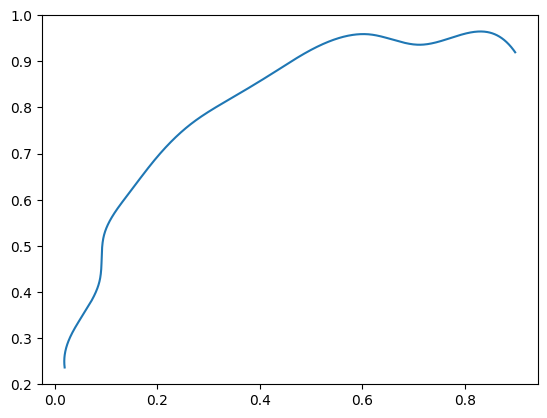

In [9]:
time_series = np.arange(positions.shape[0])
print(time_series)

plt.plot(positions[:,1], positions[:,0])

In [ ]:
# Import libraries
import numpy as np 
import pickle, os
import matplotlib.pyplot as plt
import scipy, pickle
import scipy.signal
from tqdm import tqdm
from scipy import ndimage


In [2]:
# Constants
epsilon = 1e-10

In [22]:
import pickle
import numpy as np

# Load trajectory (x, y)
with open("0_input_data/traj_5_data.pkl", "rb") as f:
    traj_data = pickle.load(f)

x = np.array(traj_data["x"])
y = np.array(traj_data["y"])
positions = np.column_stack((x, y))
print("Trajectory shape:", positions.shape)

# Load activations
with open("0_input_data/activations_z3_traj_5.pkl", "rb") as f:
    activations = pickle.load(f)
print("Activations shape:", activations.shape)  # (time_steps, num_neurons)


Trajectory shape: (1000, 2)
Activations shape: (1000, 100)


In [23]:
# 2D Occupancy Map

import scipy.signal
import matplotlib.pyplot as plt

def matlab_style_gauss2D(shape=(9,9), sigma=3):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2.*sigma*sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    h /= h.sum()
    return h

def occupancy_map_func(pos, reso=40, win_len=9):
    x, y = pos[:,0], pos[:,1]
    H, xedges, yedges = np.histogram2d(x, y, bins=(reso, reso))
    gaussian = matlab_style_gauss2D([win_len, win_len], 3.0)
    H_smooth = scipy.signal.convolve2d(H, gaussian, mode='same')
    H_smooth = H_smooth / (np.nansum(H_smooth) + 1e-10)
    H_smooth[H_smooth == 0] = np.nan
    return H_smooth, xedges, yedges


In [24]:
# Firing Rate Map

def firing_rate_map_2d(resp, pos, occ_tuple, thresh_param=0.0):
    H_occ, xedges, yedges = occ_tuple
    mean_resp = np.nanmean(resp)
    std_resp = np.nanstd(resp)
    thresh = mean_resp + thresh_param * std_resp
    spike_idx = np.where(resp > thresh)[0]
    spike_pos = pos[spike_idx]
    
    if len(spike_pos) == 0:
        return np.zeros_like(H_occ), np.nan
    
    H_spikes, _, _ = np.histogram2d(spike_pos[:,0], spike_pos[:,1], bins=(xedges, yedges))
    fr_map = H_spikes / (H_occ + 1e-10)
    fr_map[np.isnan(H_occ)] = np.nan
    
    gaussian = matlab_style_gauss2D([9,9], 3.0)
    fr_smooth = scipy.signal.convolve2d(fr_map, gaussian, mode='same')
    fr_smooth[np.isnan(H_occ)] = np.nan
    return fr_smooth, spike_pos


In [25]:
# Spatial Information and Sparsity

def inf_rate(rate_map, px):
    tmp = np.nan_to_num(rate_map)
    avg_rate = np.sum(tmp * px)
    info = np.nansum((tmp / avg_rate) * np.log2(np.maximum(tmp / avg_rate, 1e-10)) * px)
    return info, avg_rate

def sparsity_func(px, fr_map):
    px_norm = px / (np.nansum(px) + 1e-10)
    avg_rate = np.nansum(fr_map * px_norm)
    numerator = avg_rate ** 2
    denominator = np.nansum(px_norm * fr_map**2) + 1e-10
    return numerator / denominator


In [26]:
reso = 40
occ_map, xedges, yedges = occupancy_map_func(positions, reso=reso)
occ_tuple = (occ_map, xedges, yedges)

spatial_info, sparsity_scores, fr_maps = [], [], []

for i in range(activations.shape[1]):
    resp = activations[:, i]
    fr_map, _ = firing_rate_map_2d(resp, positions, occ_tuple)
    fr_maps.append(fr_map)
    
    info, avg_rate = inf_rate(fr_map, occ_map)
    spatial_info.append(info / (avg_rate + 1e-10))
    
    spar = sparsity_func(occ_map, fr_map)
    sparsity_scores.append(spar)

spatial_info = np.nan_to_num(spatial_info)
sparsity_scores = np.nan_to_num(sparsity_scores)

print("Spatial Info (first 10):", spatial_info[:10])
print("Sparsity (first 10):", sparsity_scores[:10])


Spatial Info (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sparsity (first 10): [0.38946965 0.38913694 0.38909591 0.388709   0.38865784 0.38880195
 0.38952517 0.38897205 0.38850968 0.38836475]


In [29]:
spi_threshold = 0.3
spar_threshold = 0.1

place_cells = np.where(
    (np.array(spatial_info) > spi_threshold) &
    (np.array(sparsity_scores) < spar_threshold)
)[0]

print(f"Place cells found: {place_cells}")


Place cells found: []


In [30]:
num_cols = 5
num_rows = int(np.ceil(len(place_cells) / num_cols))
plt.figure(figsize=(3*num_cols, 3*num_rows))
plt.suptitle("2D Place Fields — z1 Layer", fontsize=16)

for idx, n in enumerate(place_cells):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(np.rot90(fr_maps[n]), cmap='jet', origin='lower')
    plt.title(f"Neuron {n}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<Figure size 1500x0 with 0 Axes>

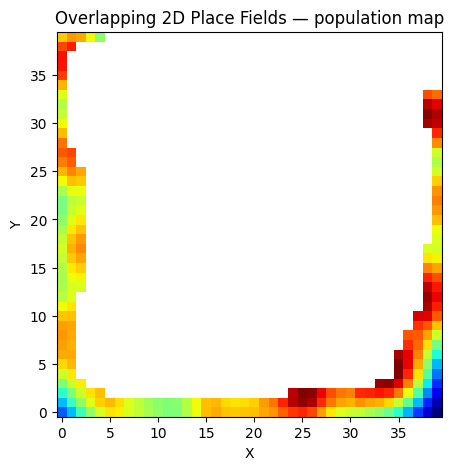

In [18]:
plt.figure(figsize=(5, 5))
plt.title("Overlapping 2D Place Fields — population map")

# Background (dark blue)
combined_field = np.zeros_like(fr_maps[0])

# Add normalized activity of each place cell
for n in place_cells:
    field = fr_maps[n]
    field_norm = field / (np.nanmax(field) + 1e-8)
    combined_field += field_norm

plt.imshow(np.rot90(combined_field), cmap='jet', origin='lower')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
